In [1]:
import os
import logging


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import dill

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoDelta
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition


from cities.utils.data_grabber import (DataGrabber, list_available_features, list_tensed_features, list_interventions, list_outcomes)
from cities.utils.cleaning_utils import check_if_tensed, find_repo_root
from cities.modeling.model_interactions import cities_model_interactions as model
from cities.modeling.model_interactions import InteractionsModel
from cities.modeling.modeling_utils import (prep_data_for_interaction_inference,  train_interactions_model)
from cities.utils.cleaning_utils import find_repo_root


In [2]:
list_interventions = list_interventions()
print(list_interventions)

['spending_HHS', 'spending_commerce', 'spending_transportation']


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


#outcome_dataset='industry_transportation_warehousing_total'
#intervention_dataset='spending_transportation'
intervention_dataset='spending_commerce'
outcome_dataset='gdp'
forward_shift = 2

dg = DataGrabber()

dg.get_features_std_long([intervention_dataset, outcome_dataset])

intervention_variable = dg.std_long[intervention_dataset].columns[-1]

tensed_covariates_datasets = [
    var
    for var in list_tensed_features()
    if var not in [outcome_dataset, intervention_dataset]
]
fixed_covariates_datasets = [
    var
    for var in list_available_features()
    if var
    not in tensed_covariates_datasets + [outcome_dataset, intervention_dataset]
]

features_needed = [outcome_dataset, intervention_dataset] + fixed_covariates_datasets

#dg.get_features_std_long(features_needed)
dg.get_features_std_wide(features_needed)


intervention = dg.std_wide[intervention_dataset]
outcome = dg.std_wide[outcome_dataset]

# put covariates in one df as columns, dropping repeated ID columns
f_covariates = {
    dataset: dg.std_wide[dataset] for dataset in fixed_covariates_datasets
}
f_covariates_joint = f_covariates[fixed_covariates_datasets[0]]
for dataset in f_covariates.keys():
    if dataset != fixed_covariates_datasets[0]:
        if "GeoName" in f_covariates[dataset].columns:
            f_covariates[dataset] = f_covariates[dataset].drop(columns=["GeoName"])
        f_covariates_joint = f_covariates_joint.merge(
            f_covariates[dataset], on=["GeoFIPS"]
        )

assert f_covariates_joint['GeoFIPS'].equals(intervention['GeoFIPS'])

year_min =  max(
intervention.columns[2:].astype(int).min(),
outcome.columns[2:].astype(int).min(),
)

year_max = min(
    intervention.columns[2:].astype(int).max(),
    outcome.columns[2:].astype(int).max(),
)

assert all(intervention['GeoFIPS'] == outcome['GeoFIPS'])


outcome_years_to_keep = [year for year in outcome.columns[2:] 
                        if year_min <= int(year) <= year_max +forward_shift]

outcome_years_to_keep = [year for year in outcome_years_to_keep if year in intervention.columns[2:]]

outcome = outcome[outcome_years_to_keep]
outcome_shifted = outcome.copy()
 
for i in range(len(outcome_years_to_keep)  - forward_shift):
    outcome_shifted.iloc[:, i] = outcome_shifted.iloc[:, i + forward_shift]

years_to_drop = [f"{year}" for year in range(year_max - forward_shift + 1, year_max + 1) ] 
outcome_shifted.drop(columns= years_to_drop, inplace=True)

intervention.drop(columns = ['GeoFIPS', "GeoName"], inplace=True)
intervention  = intervention[outcome_shifted.columns]

assert intervention.shape == outcome_shifted.shape


unit_index = pd.factorize(f_covariates_joint['GeoFIPS'].values)[0]
state_index = pd.factorize(f_covariates_joint['GeoFIPS'].values // 1000)[0]


# prepare tensors
x = torch.tensor(f_covariates_joint.iloc[:, 2:].values, dtype=torch.float32, device=device)
x = x.unsqueeze(1).unsqueeze(1).permute(2,3, 1, 0)

t = torch.tensor(intervention.iloc[:, 2:].values, dtype=torch.int, device=device)
t = t.unsqueeze(1).unsqueeze(1).permute(3, 1, 2, 0)

y = torch.tensor(outcome_shifted.iloc[:, 2:].values, dtype=torch.float32, device=device)
y = y.unsqueeze(1).unsqueeze(1).permute(3, 1, 2, 0)

state_index = torch.tensor(state_index, dtype=torch.int, device=device)
unit_index = torch.tensor(unit_index, dtype=torch.int, device=device)

N_t = y.shape[0]
N_cov = x.shape[1]
N_s = state_index.unique().shape[0]
N_u = unit_index.unique().shape[0]

assert x.shape == (1, N_cov, 1, N_u)
assert y.shape == (N_t, 1, 1, N_u)
assert t.shape == (N_t, 1, 1, N_u)

model_args = (N_t, N_cov, N_s, N_u, state_index, unit_index)


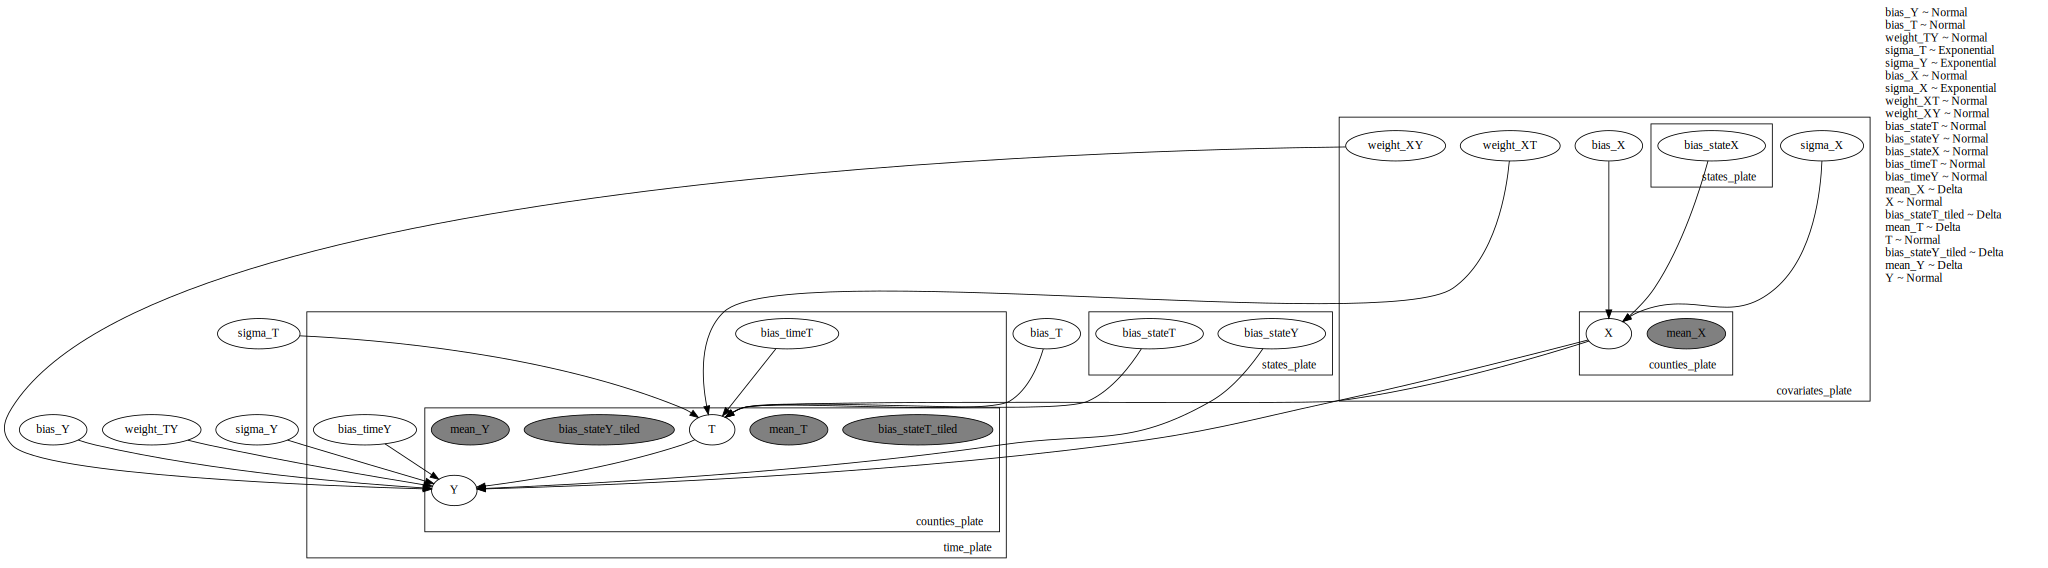

In [4]:
def model_cities_interaction(
    N_t,
    N_cov,
    N_s,
    N_u,
    state_index,
    unit_index,
    leeway=0.2,
):
    bias_Y = pyro.sample("bias_Y", dist.Normal(0, leeway))
    bias_T = pyro.sample("bias_T", dist.Normal(0, leeway))

    weight_TY = pyro.sample("weight_TY", dist.Normal(0, leeway))

    sigma_T = pyro.sample("sigma_T", dist.Exponential(1))
    sigma_Y = pyro.sample("sigma_Y", dist.Exponential(1))
 
    counties_plate = pyro.plate("counties_plate", N_u, dim=-1)
    states_plate = pyro.plate("states_plate", N_s, dim=-2)
    covariates_plate = pyro.plate("covariates_plate", N_cov, dim=-3)
    time_plate = pyro.plate("time_plate", N_t, dim=-4)

    with covariates_plate:
        bias_X = pyro.sample("bias_X", dist.Normal(0, leeway))
        sigma_X = pyro.sample("sigma_X", dist.Exponential(1))
        weight_XT = pyro.sample("weight_XT", dist.Normal(0, leeway))
        weight_XY = pyro.sample("weight_XY", dist.Normal(0, leeway))

    with states_plate:
        bias_stateT = pyro.sample("bias_stateT", dist.Normal(0, leeway))
        bias_stateY = pyro.sample("bias_stateY", dist.Normal(0, leeway))

        with covariates_plate:
            bias_stateX = pyro.sample("bias_stateX", dist.Normal(0, leeway))

    with time_plate:
        bias_timeT = pyro.sample("bias_timeT", dist.Normal(0, leeway))
        bias_timeY = pyro.sample("bias_timeY", dist.Normal(0, leeway))

    with counties_plate:
        with covariates_plate:
        
            mean_X = pyro.deterministic("mean_X", torch.einsum("...xdd,...xcd->...xdc", bias_X, bias_stateX[...,state_index,:])) 
            
            X = pyro.sample("X", dist.Normal(mean_X[...,unit_index], sigma_X)) 
        
            XT_weighted =  torch.einsum("...xdc, ...xdd -> ...dc", X, weight_XT).unsqueeze(-2)
            XY_weighted =  torch.einsum("...xdc, ...xdd -> ...dc", X, weight_XY).unsqueeze(-2)

        with time_plate:
            
            bias_stateT_tiled = pyro.deterministic("bias_stateT_tiled", torch.einsum("...cd -> ...dc", bias_stateT[...,state_index,:]))
            
            mean_T = pyro.deterministic("mean_T",  bias_T + bias_timeT + bias_stateT_tiled +  XT_weighted)

            T = pyro.sample("T", dist.Normal(mean_T, sigma_T))
            
            bias_stateY_tiled = pyro.deterministic("bias_stateY_tiled", torch.einsum("...cd -> ...dc", 
                                                                        bias_stateY[...,state_index,:]))

            mean_Y = pyro.deterministic("mean_Y", 
                                        bias_Y + bias_timeY + bias_stateY_tiled + XY_weighted + weight_TY * T)
            Y = pyro.sample("Y", dist.Normal(mean_Y, sigma_Y))

    return Y

# with pyro.poutine.trace() as tr:
#     model_cities_interaction(*model_args)
  
# for key in tr.trace.nodes.keys():
#     if not key.endswith("plate"):
#         print(key, tr.trace.nodes[key]["value"].shape)


pyro.render_model( 
            model_cities_interaction, model_args=model_args, render_distributions=True
        )

In [5]:
model_conditioned =  pyro.condition(model_cities_interaction, data={"X": x, "T": t, "Y": y},)


[iteration 0001] loss: 242506.9225
[iteration 0101] loss: 26799.7663
[iteration 0201] loss: 4274.1895
[iteration 0301] loss: 3643.0863
[iteration 0401] loss: 3096.9226
[iteration 0501] loss: 2930.4864
[iteration 0601] loss: 2533.8082
[iteration 0701] loss: 2449.0636
[iteration 0801] loss: 2383.5222
[iteration 0901] loss: 2367.3092


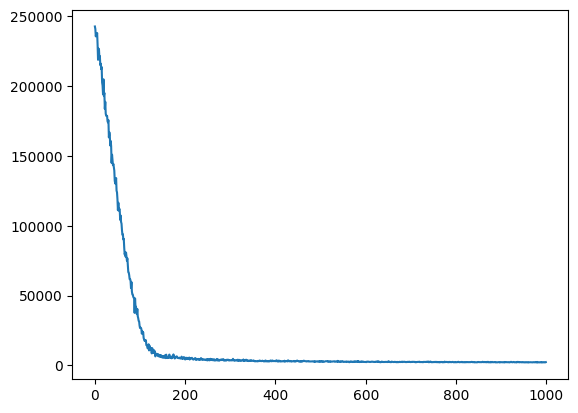

In [7]:
pyro.clear_param_store()
num_iterations = 1000
plot_loss = True
print_interval = 100
lr = 0.01


guide = AutoNormal(model_cities_interaction)

svi = SVI(model=model_cities_interaction, guide=guide, optim=Adam({"lr": lr}), loss=Trace_ELBO())

losses = []
for step in range(num_iterations):
    loss = svi.step(*model_args)
    losses.append(loss)
    if step % print_interval == 0:
        print("[iteration %04d] loss: %.4f" % (step + 1, loss))


plt.plot(range(num_iterations), losses, label="Loss")
plt.show()


In [8]:
predictive = Predictive(model=model_cities_interaction, guide=guide, num_samples=1000, parallel=False)
samples = predictive(*model_args)


In [9]:
predictions = samples['Y'].squeeze()

torch.Size([1000, 7, 3074])
torch.Size([7, 3074])
torch.Size([7, 3074])


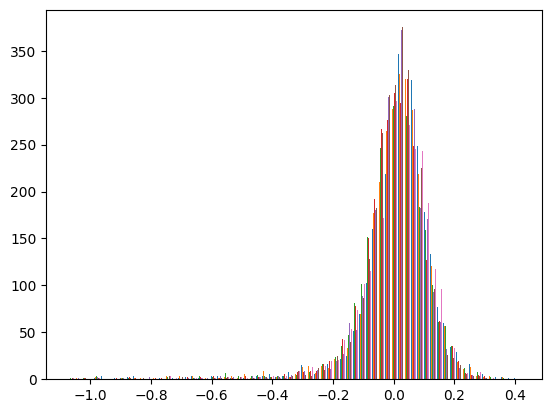

tss tensor(267.6495)
rss tensor(2153.4072)
r_squared tensor(-7.0456)


In [12]:
# plot residuals
predictions = samples['Y'].squeeze()

print(predictions.shape)

average_predictions = torch.mean(predictions, dim=0)

print(average_predictions.shape)

print(y.squeeze().shape)

plt.hist(average_predictions -y.squeeze(), bins=70)
plt.show()




In [23]:
y_flat = y.view(-1)

observed_mean = torch.mean(y_flat)
print(observed_mean)

tss = torch.sum((y_flat- observed_mean) ** 2)
print("tss", tss)

average_predictions_flat = average_predictions.view(-1)
print(average_predictions_flat.shape)

plt.scatter(average_predictions_flat, y_flat)


rss = torch.sum((y_flat- average_predictions_flat) ** 2)
print("rss", rss)
r_squared = 1 - (rss / tss)
print("r_squared", r_squared)

tensor(-0.0044)
tss tensor(267.6495)
torch.Size([21518])
rss tensor(307.9418)
r_squared tensor(-0.1505)


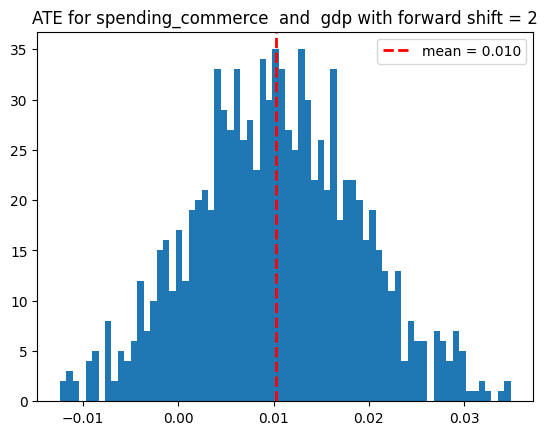

In [11]:
tau_samples = samples['weight_TY'].squeeze().detach().numpy()

plt.hist(tau_samples,bins = 70)
plt.axvline(x=tau_samples.mean(), color='red', linestyle='dashed', linewidth=2, label=f'mean = {tau_samples.mean():.3f}')
plt.title(f"ATE for {intervention_dataset}  and  {outcome_dataset} with forward shift = {forward_shift}")
plt.legend()
plt.show()